# What is this flower?
___
## (Model training pipeline)

## Setting up dependencies

In [1]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


Loading the repository that stores a python package containing the functions and classes for classifying images using neural networks.

In [2]:
!git clone https://github.com/vimaki/what_is_this_flower.git

Cloning into 'what_is_this_flower'...
remote: Enumerating objects: 207, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 207 (delta 101), reused 162 (delta 56), pack-reused 0
Receiving objects: 100% (207/207), 1.65 MiB | 8.01 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [3]:
%cd /content/what_is_this_flower

/content/what_is_this_flower


In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 95 kB 2.8 MB/s 
     |████████████████████████████████| 13.1 MB 21.1 MB/s 
     |████████████████████████████████| 15.7 MB 29.4 MB/s 
     |████████████████████████████████| 308 kB 41.3 MB/s 
     |████████████████████████████████| 904 kB 60.5 MB/s 
     |████████████████████████████████| 23.1 MB 1.3 MB/s 
     |████████████████████████████████| 61 kB 454 kB/s 
     |████████████████████████████████| 288 kB 76.4 MB/s 
     |████████████████████████████████| 133 kB 80.1 MB/s 
     |████████████████████████████████| 80 kB 10.0 MB/s 
     |████████████████████████████████| 209 kB 80.6 MB/s 
     |████████████████████████████████| 75 kB 5.4 MB/s 
     |████████████████████████████████| 49 kB 7.8 MB/s 
     |████████████████████████████████| 112 kB 79.9 MB/s 
     |████████████████████████████████| 149 kB 76.3 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=042ec6724830560c95558309cb94237d78a

In [5]:
%cd /content/what_is_this_flower/predictive_model

/content/what_is_this_flower/predictive_model


In [6]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
from google.colab import drive
from torch import load
from torch.utils.data import DataLoader
from torchvision import models
from varname import nameof

import model_utils as mu

In [7]:
%matplotlib inline

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [8]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    print('GPU is not available')

In [9]:
# connecting Google Colab to Google Drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [10]:
%cd ../..

/content


## Fix Random Seed

In [11]:
def set_seed(seed):
    """ Фиксация начальных значений генераторов случайных чисел """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 0
set_seed(SEED)

## Loading data

Loading data from Kaggle and creating Pytorch datasets from them

In [12]:
%%bash
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download vitalymakin/flower-from-shops-classification

100%|##########| 4.09G/4.09G [01:56<00:00, 37.6MB/s]


In [13]:
!unzip -q '/content/flower-from-shops-classification.zip' -d flowers_dataset

In [14]:
flowers_dataset = 'flowers_dataset/dataset'
train_dataset, val_dataset, test_dataset = mu.upload_dataset(flowers_dataset, random_state=SEED)

In [15]:
# Checking the distribution of classes in the training dataset
print(train_dataset.class_distribution())

alstroemeria          163
amaranth               68
amaryllis             176
ammi                  152
anemone               145
anthurium             169
antirrhinum           149
aster                 149
astilbe               139
astrantia             147
bouvardia             143
brassica               87
calla                 179
carnation             145
celosia               184
chamelaucium          143
chamomile             131
chrysanthemum         144
cotton                 71
craspedia             140
dahlia                181
delphinium            147
eryngium              155
eustoma               143
forget-me-not         140
freesia               133
gerbera               167
gladiolus             151
gypsophila             97
hyacinth              147
hydrangea             123
hypericum             132
iris                  142
lavender               98
leucadendron          166
leucospermum          157
lilac                 116
lily                  107
lily_of_the_

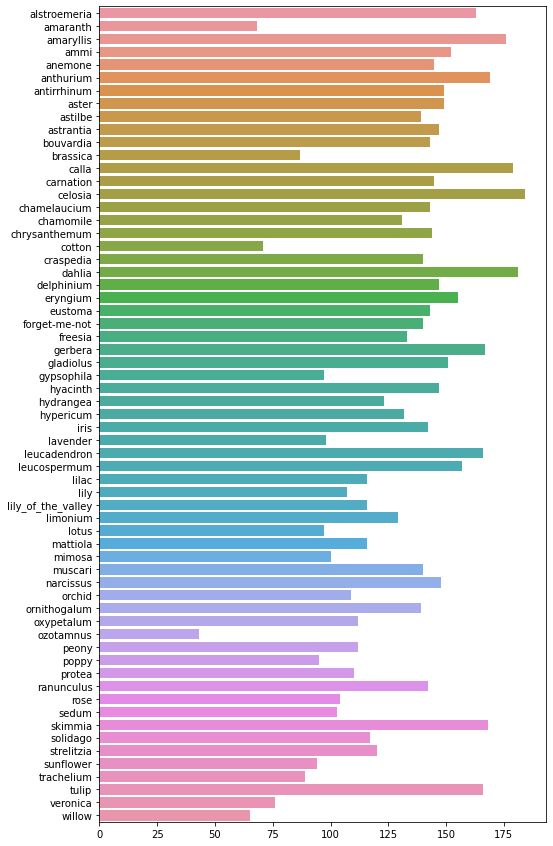

In [16]:
# Class size histogram
class_distr = dict(train_dataset.class_distribution())
label_names = list(class_distr.keys())
class_size = [class_distr[k] for k in label_names]
plt.figure(figsize=(8, 15))
sns.barplot(x=class_size, y=label_names);

###### Balancing classes

In [17]:
class_median = int(np.median([cls[1] for cls in train_dataset.class_distribution()]))
class_median

139

In [18]:
train_dataset, val_dataset, test_dataset = mu.upload_dataset(
    flowers_dataset, random_state=SEED, balance=class_median
)

In [19]:
print(train_dataset.class_distribution())

alstroemeria          163
amaranth              139
amaryllis             176
ammi                  152
anemone               145
anthurium             169
antirrhinum           149
aster                 149
astilbe               139
astrantia             147
bouvardia             143
brassica              139
calla                 179
carnation             145
celosia               184
chamelaucium          143
chamomile             139
chrysanthemum         144
cotton                139
craspedia             140
dahlia                181
delphinium            147
eryngium              155
eustoma               143
forget-me-not         140
freesia               139
gerbera               167
gladiolus             151
gypsophila            139
hyacinth              147
hydrangea             139
hypericum             139
iris                  142
lavender              139
leucadendron          166
leucospermum          157
lilac                 139
lily                  139
lily_of_the_

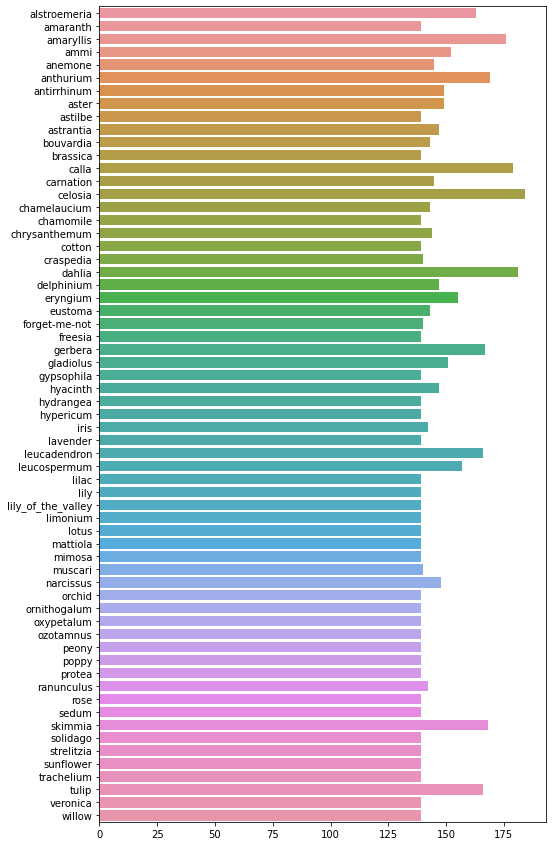

In [20]:
# Class size histogram
class_distr = dict(train_dataset.class_distribution())
label_names = list(class_distr.keys())
class_size = [class_distr[k] for k in label_names]
plt.figure(figsize=(8, 15))
sns.barplot(x=class_size, y=label_names);

In [21]:
# The number of flowers in the dataset
n_classes = len(np.unique(train_dataset.labels))
n_classes

63

###### Example of images from the training dataset

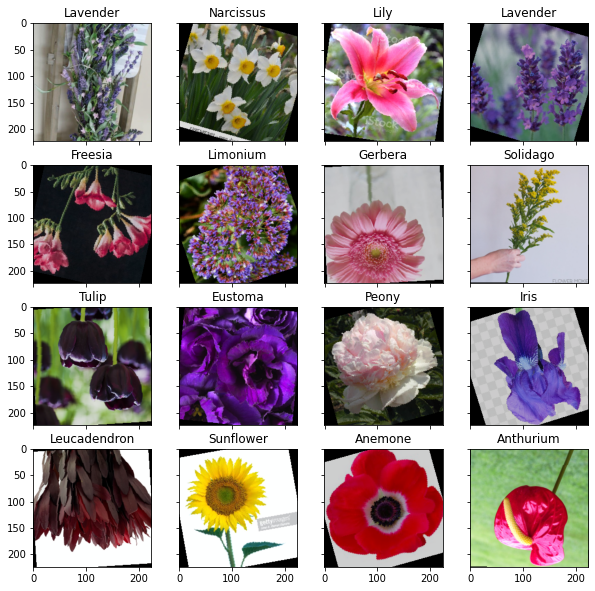

In [22]:
mu.show_dataset_examples(train_dataset)

## Training of model EfficientNet B5

### Training of model's classifier

#### Selection of optimal model hyperparameters

In [ ]:
def objective(trial):
    """A function to be optimized with hyperparameters."""
    # Setting the search space for hyperparameters
    params = {
        'batch_size': trial.suggest_int('batch_size', 2, 64),
        'lr': trial.suggest_loguniform('lr', 1e-4, 1e-1),
        'T_max': trial.suggest_int('T_max', 4, 100)
    }
    
    # Creating storage structures for training
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    # Setting the architecture of the neural network
    model = models.efficientnet_b5(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, n_classes)
    model = model.to(DEVICE)
    
    # Setting methods for setting up a neural network
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"], amsgrad=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params['T_max'])

    # Start training a neural network with the selected parameters
    for epoch in range(5):

            train_loss, train_acc = mu.fit_epoch(model, train_loader, loss_func, optimizer, on_gpu=True)
            val_loss, val_acc = mu.eval_epoch(model, val_loader, loss_func, on_gpu=True, checkpoint=False)

            trial.report(val_acc, epoch)

            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    return val_acc

Hyperparameter fitting calculations were performed on a third-party platform (kaggle.com), so the outputs of the executed cells were not saved. The calculation results are presented below as screenshots.

In [ ]:
# Running the hyperparameter selection algorithm and displaying the results
mu.run_tuning(objective, n_trials=25, seed=SEED)

[I 2022-01-04 22:11:40,149] A new study created in memory with name: no-name-bbcef965-9cce-4366-be09-acf8c51486a8
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

  0%|          | 0/257 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

[I 2022-01-04 22:39:04,878] Trial 0 finished with value: 0.5556784660766961 and parameters: {'batch_size': 36, 'lr': 0.013981961408994055, 'T_max': 62}. Best is trial 0 with value: 0.5556784660766961.


  0%|          | 0/257 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

[I 2022-01-04 23:05:32,149] Trial 1 finished with value: 0.6482300884955752 and parameters: {'batch_size': 36, 'lr': 0.0018662266976517971, 'T_max': 66}. Best is trial 1 with value: 0.6482300884955752.


  0%|          | 0/319 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

[I 2022-01-04 23:31:43,638] Trial 2 finished with value: 0.504424778761062 and parameters: {'batch_size': 29, 'lr': 0.04734989304499478, 'T_max': 97}. Best is trial 1 with value: 0.6482300884955752.


  0%|          | 0/356 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

[I 2022-01-04 23:57:43,248] Trial 3 finished with value: 0.5342920353982301 and parameters: {'batch_size': 26, 'lr': 0.02372330072992195, 'T_max': 55}. Best is trial 1 with value: 0.6482300884955752.


  0%|          | 0/250 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

[I 2022-01-05 00:23:39,154] Trial 4 finished with value: 0.5224926253687315 and parameters: {'batch_size': 37, 'lr': 0.05981221901152557, 'T_max': 10}. Best is trial 1 with value: 0.6482300884955752.


  0%|          | 0/1320 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/388 [00:00<?, ?it/s]

[I 2022-01-05 00:29:29,273] Trial 5 pruned. 


  0%|          | 0/182 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

[I 2022-01-05 00:55:05,074] Trial 6 finished with value: 0.5519911504424778 and parameters: {'batch_size': 51, 'lr': 0.04074144654166233, 'T_max': 98}. Best is trial 1 with value: 0.6482300884955752.


  0%|          | 0/178 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[I 2022-01-05 01:20:37,297] Trial 7 finished with value: 0.6375368731563422 and parameters: {'batch_size': 52, 'lr': 0.0024234724484675954, 'T_max': 79}. Best is trial 1 with value: 0.6482300884955752.


  0%|          | 0/1027 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/302 [00:00<?, ?it/s]

[I 2022-01-05 01:26:17,766] Trial 8 pruned. 


  0%|          | 0/152 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[I 2022-01-05 01:52:02,129] Trial 9 finished with value: 0.6721976401179941 and parameters: {'batch_size': 61, 'lr': 0.0036774346621052147, 'T_max': 44}. Best is trial 9 with value: 0.6721976401179941.


  0%|          | 0/149 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/44 [00:00<?, ?it/s]

[I 2022-01-05 01:57:14,783] Trial 10 pruned. 


  0%|          | 0/149 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

[I 2022-01-05 02:23:10,910] Trial 11 finished with value: 0.6578171091445427 and parameters: {'batch_size': 62, 'lr': 0.002123659586221481, 'T_max': 40}. Best is trial 9 with value: 0.6721976401179941.


  0%|          | 0/152 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/45 [00:00<?, ?it/s]

[I 2022-01-05 02:28:25,719] Trial 12 pruned. 


  0%|          | 0/193 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

[I 2022-01-05 02:54:16,205] Trial 13 finished with value: 0.6390117994100295 and parameters: {'batch_size': 48, 'lr': 0.005592942794265217, 'T_max': 36}. Best is trial 9 with value: 0.6721976401179941.


  0%|          | 0/145 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/43 [00:00<?, ?it/s]

[I 2022-01-05 02:59:35,419] Trial 14 pruned. 


  0%|          | 0/206 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/61 [00:00<?, ?it/s]

[I 2022-01-05 03:04:48,621] Trial 15 pruned. 


  0%|          | 0/165 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

[I 2022-01-05 03:30:40,323] Trial 16 finished with value: 0.6541297935103245 and parameters: {'batch_size': 56, 'lr': 0.0039482801349592445, 'T_max': 47}. Best is trial 9 with value: 0.6721976401179941.


  0%|          | 0/402 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/118 [00:00<?, ?it/s]

[I 2022-01-05 03:35:55,435] Trial 17 pruned. 


  0%|          | 0/220 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-01-05 03:46:14,947] Trial 18 pruned. 


  0%|          | 0/544 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/160 [00:00<?, ?it/s]

[I 2022-01-05 03:51:38,104] Trial 19 pruned. 


  0%|          | 0/160 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-01-05 03:56:50,529] Trial 20 pruned. 


  0%|          | 0/172 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

[I 2022-01-05 04:23:30,723] Trial 21 finished with value: 0.648598820058997 and parameters: {'batch_size': 54, 'lr': 0.004341244052662451, 'T_max': 44}. Best is trial 9 with value: 0.6721976401179941.


  0%|          | 0/163 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

[I 2022-01-05 04:50:39,588] Trial 22 finished with value: 0.6592920353982301 and parameters: {'batch_size': 57, 'lr': 0.0035032172511448912, 'T_max': 50}. Best is trial 9 with value: 0.6721976401179941.


  0%|          | 0/163 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

[I 2022-01-05 05:17:17,126] Trial 23 finished with value: 0.6648230088495575 and parameters: {'batch_size': 57, 'lr': 0.002866985660416096, 'T_max': 50}. Best is trial 9 with value: 0.6721976401179941.


  0%|          | 0/220 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  delete_trns = True


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-01-05 05:22:34,718] Trial 24 pruned. 


Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:  11
  Number of complete trials:  14
Best trial:
  Value:  0.6721976401179941
  Params: 
    batch_size: 61
    lr: 0.0036774346621052147
    T_max: 44


##### Results of fitting model hyperparameters

Visualize the learning curves of the trials

<img src="https://github.com/vimaki/what_is_this_flower/blob/main/predictive_model/plots/plot_intermediate_values.png?raw=true" width="500">

Visualize combinations of hyperparameters for all trials with display of the objective value

<img src="https://github.com/vimaki/what_is_this_flower/blob/main/predictive_model/plots/plot_parallel_coordinate.png?raw=true" width="500">

The projections onto the surface plane of the objective value depending on all pairs of parameters

<img src="https://github.com/vimaki/what_is_this_flower/blob/main/predictive_model/plots/plot_contour.png?raw=true" width="500">

Visualize parameter importances

<img src="https://github.com/vimaki/what_is_this_flower/blob/main/predictive_model/plots/plot_param_importances.png?raw=true" width="500">

Visualize which hyperparameters are affecting the trial duration with hyperparameter importance

<img src="https://github.com/vimaki/what_is_this_flower/blob/main/predictive_model/plots/plot_param_duration.png?raw=true" width="500">

<img src="https://github.com/vimaki/what_is_this_flower/blob/main/predictive_model/plots/tuning_result.png?raw=true" width="300">

In [ ]:
BATCH_SIZE = 61
LR = 0.0036774346621052147
T_MAX = 44

#### Running Model's Classifier Training

In [ ]:
# Load the model EfficientNet B5 pretrained on ImageNet
model_effnet_b5 = models.efficientnet_b5(pretrained=True)

# Disable the computation of gradients for the model weights
for param in model_effnet_b5.parameters():
    param.requires_grad = False

# Set a new classifier for the model
model_effnet_b5.classifier[1] = torch.nn.Linear(model_effnet_b5.classifier[1].in_features, n_classes)
model_effnet_b5 = model_effnet_b5.to(DEVICE)

# Helper functions for training the model
loss_func_effnet_b5 = torch.nn.CrossEntropyLoss()
optimizer_effnet_b5 = torch.optim.AdamW(model_effnet_b5.parameters(), lr=LR, amsgrad=True)
scheduler_effnet_b5 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_effnet_b5, T_max=T_MAX)

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



  0%|          | 0/152 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning:

Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



loss 2.554360194477802


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:   3%|▎         | 1/30 [07:42<3:43:23, 462.19s/it]


Epoch 001 train_loss: 2.5544     val_loss 1.7514 train_acc 0.3929 val_acc 0.5516


  0%|          | 0/152 [00:00<?, ?it/s]

loss 1.353598331039527


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:   7%|▋         | 2/30 [15:12<3:32:28, 455.32s/it]


Epoch 002 train_loss: 1.3536     val_loss 1.4095 train_acc 0.6500 val_acc 0.6287


  0%|          | 0/152 [00:00<?, ?it/s]

loss 1.0342649378369722


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  10%|█         | 3/30 [22:34<3:22:10, 449.26s/it]


Epoch 003 train_loss: 1.0343     val_loss 1.2902 train_acc 0.7281 val_acc 0.6549


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.8585671055828044


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  13%|█▎        | 4/30 [29:55<3:13:08, 445.69s/it]


Epoch 004 train_loss: 0.8586     val_loss 1.2837 train_acc 0.7756 val_acc 0.6556


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.7831634580250063


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  17%|█▋        | 5/30 [36:55<3:01:52, 436.49s/it]


Epoch 005 train_loss: 0.7832     val_loss 1.2660 train_acc 0.7936 val_acc 0.6549


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.6956998459533367


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  20%|██        | 6/30 [44:05<2:53:46, 434.44s/it]


Epoch 006 train_loss: 0.6957     val_loss 1.2641 train_acc 0.8120 val_acc 0.6700


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.6334165950624805


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  23%|██▎       | 7/30 [51:12<2:45:36, 432.00s/it]


Epoch 007 train_loss: 0.6334     val_loss 1.2427 train_acc 0.8257 val_acc 0.6619


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.5841598197520941


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  27%|██▋       | 8/30 [58:18<2:37:39, 429.97s/it]


Epoch 008 train_loss: 0.5842     val_loss 1.2064 train_acc 0.8435 val_acc 0.6692


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.5480931249014378


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  30%|███       | 9/30 [1:05:24<2:30:05, 428.83s/it]


Epoch 009 train_loss: 0.5481     val_loss 1.2127 train_acc 0.8489 val_acc 0.6799


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.5023366757682672


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  33%|███▎      | 10/30 [1:12:45<2:24:10, 432.55s/it]


Epoch 010 train_loss: 0.5023     val_loss 1.2057 train_acc 0.8611 val_acc 0.6822


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.4739351601841234


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  37%|███▋      | 11/30 [1:20:17<2:18:50, 438.44s/it]


Epoch 011 train_loss: 0.4739     val_loss 1.2560 train_acc 0.8689 val_acc 0.6707


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.4583658436228569


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  40%|████      | 12/30 [1:27:44<2:12:18, 441.04s/it]


Epoch 012 train_loss: 0.4584     val_loss 1.2555 train_acc 0.8793 val_acc 0.6678


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.4374415921753183


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  43%|████▎     | 13/30 [1:35:11<2:05:31, 443.04s/it]


Epoch 013 train_loss: 0.4374     val_loss 1.2342 train_acc 0.8800 val_acc 0.6748


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.4186679505815285


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  47%|████▋     | 14/30 [1:42:29<1:57:43, 441.48s/it]


Epoch 014 train_loss: 0.4187     val_loss 1.2358 train_acc 0.8858 val_acc 0.6796


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.3968896278752528


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  50%|█████     | 15/30 [1:49:36<1:49:14, 436.94s/it]


Epoch 015 train_loss: 0.3969     val_loss 1.2525 train_acc 0.8970 val_acc 0.6704


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.36559588364182277


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  53%|█████▎    | 16/30 [1:56:37<1:40:52, 432.30s/it]


Epoch 016 train_loss: 0.3656     val_loss 1.2134 train_acc 0.8998 val_acc 0.6803


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.36492832293173305


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  57%|█████▋    | 17/30 [2:03:48<1:33:35, 431.98s/it]


Epoch 017 train_loss: 0.3649     val_loss 1.2266 train_acc 0.9032 val_acc 0.6785


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.3557507251234037


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  60%|██████    | 18/30 [2:10:58<1:26:15, 431.29s/it]


Epoch 018 train_loss: 0.3558     val_loss 1.2189 train_acc 0.9039 val_acc 0.6818


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.3508795880736366


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  63%|██████▎   | 19/30 [2:18:12<1:19:12, 432.05s/it]


Epoch 019 train_loss: 0.3509     val_loss 1.1775 train_acc 0.9060 val_acc 0.6866


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.3367155468572962


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  67%|██████▋   | 20/30 [2:25:24<1:12:01, 432.13s/it]


Epoch 020 train_loss: 0.3367     val_loss 1.2538 train_acc 0.9161 val_acc 0.6833


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.32281047222920445


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  70%|███████   | 21/30 [2:32:42<1:05:05, 433.90s/it]


Epoch 021 train_loss: 0.3228     val_loss 1.1926 train_acc 0.9145 val_acc 0.6892


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.3139302241900309


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  73%|███████▎  | 22/30 [2:40:02<58:04, 435.55s/it]


Epoch 022 train_loss: 0.3139     val_loss 1.2019 train_acc 0.9180 val_acc 0.6818


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.297543473688554


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  77%|███████▋  | 23/30 [2:47:20<50:54, 436.35s/it]


Epoch 023 train_loss: 0.2975     val_loss 1.1914 train_acc 0.9245 val_acc 0.6829


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.30653005596871447


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  80%|████████  | 24/30 [2:54:41<43:45, 437.65s/it]


Epoch 024 train_loss: 0.3065     val_loss 1.1745 train_acc 0.9204 val_acc 0.6899


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.3063224225707155


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  83%|████████▎ | 25/30 [3:02:09<36:45, 441.03s/it]


Epoch 025 train_loss: 0.3063     val_loss 1.1969 train_acc 0.9231 val_acc 0.6810


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.2839815182996137


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  87%|████████▋ | 26/30 [3:09:27<29:20, 440.07s/it]


Epoch 026 train_loss: 0.2840     val_loss 1.1904 train_acc 0.9288 val_acc 0.6917


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.27327731867462407


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  90%|█████████ | 27/30 [3:16:43<21:56, 438.70s/it]


Epoch 027 train_loss: 0.2733     val_loss 1.1570 train_acc 0.9334 val_acc 0.6991


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.273000337358527


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  93%|█████████▎| 28/30 [3:23:52<14:31, 435.84s/it]


Epoch 028 train_loss: 0.2730     val_loss 1.2071 train_acc 0.9310 val_acc 0.6906


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.2750448765238806


  0%|          | 0/45 [00:00<?, ?it/s]

epoch:  97%|█████████▋| 29/30 [3:31:05<07:14, 434.99s/it]


Epoch 029 train_loss: 0.2750     val_loss 1.1650 train_acc 0.9288 val_acc 0.6936


  0%|          | 0/152 [00:00<?, ?it/s]

loss 0.26362814188274586


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 100%|██████████| 30/30 [3:38:15<00:00, 436.51s/it]



Epoch 030 train_loss: 0.2636     val_loss 1.1513 train_acc 0.9323 val_acc 0.7083


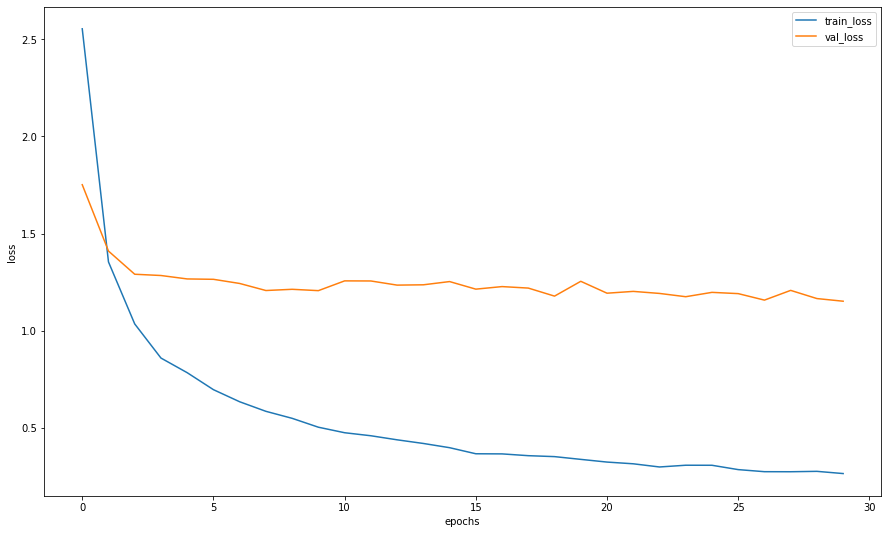

In [ ]:
# Start training the model
history_effnet_b5 = mu.train(train_dataset, val_dataset, model_effnet_b5, 
                             loss_func_effnet_b5, optimizer_effnet_b5, 
                             scheduler_effnet_b5, epochs=30, batch_size=BATCH_SIZE, 
                             model_name=nameof(model_effnet_b5))

# Save model weights
torch.save({
            'model_state_dict': model_effnet_b5.state_dict(),
            'optimizer_state_dict': optimizer_effnet_b5.state_dict(),
            }, './gdrive/My Drive/flowers/models/model_effnet_b5_weights.pth')

# Plot learning curves for model EfficientNet B5
loss_effnet_b5, acc_effnet_b5, val_loss_effnet_b5, val_acc_effnet_b5 = zip(*history_effnet_b5)
mu.plot_epoch_loss(loss_effnet_b5, val_loss_effnet_b5)

#### Intermediate quality check of the model

In [23]:
# Load the model EfficientNet B5 pretrained on ImageNet
model_effnet_b5 = models.efficientnet_b5(pretrained=True)

# Able the computation of gradients for the all model weights
for param in model_effnet_b5.parameters():
    param.requires_grad = True

# Set a new classifier for the model
model_effnet_b5.classifier[1] = torch.nn.Linear(model_effnet_b5.classifier[1].in_features, n_classes)
model_effnet_b5 = model_effnet_b5.to(DEVICE)

# Load the weights obtained at the previous stage of training
path_to_weights = './gdrive/My Drive/flowers/models/model_effnet_b5_weights.pth'
model_effnet_b5.load_state_dict(load(path_to_weights)['model_state_dict'])

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

<All keys matched successfully>

In [24]:
# Computing model predictions
predictions_effnet_b5 = mu.predict(model_effnet_b5, val_dataset, do_tta=True)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



In [25]:
# Calculation of the F1-score
f1_effnet_b5 = mu.model_f1(val_dataset, predictions_effnet_b5)
f1_effnet_b5

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



0.7695427728613571

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Normalized confusion matrix


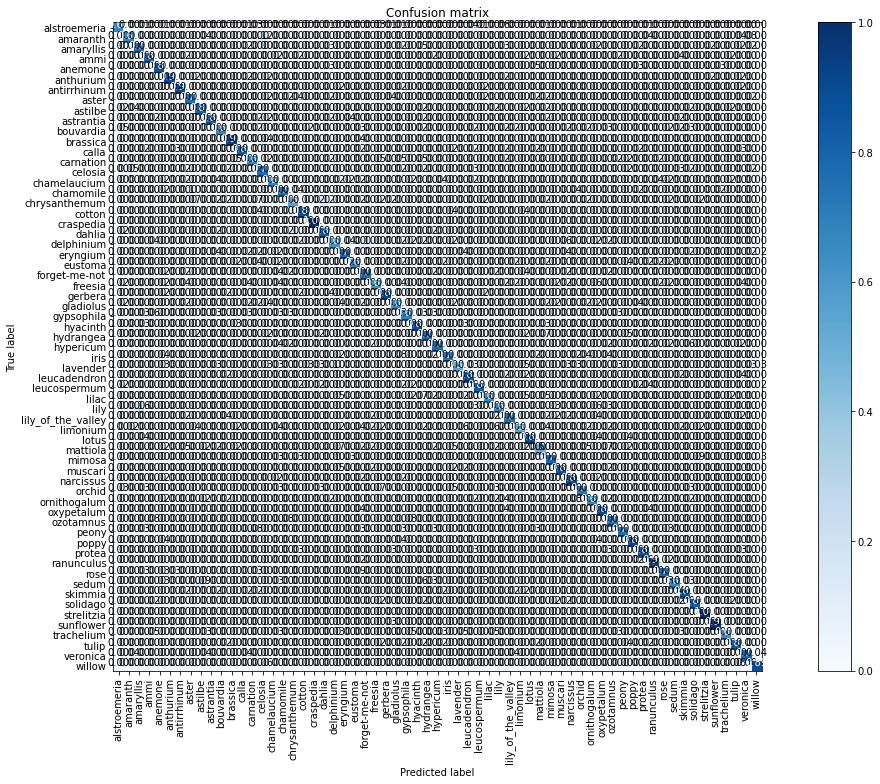

In [26]:
# Display the distribution of accuracy by class as a confusion matrix
y_test_all_effnet_b5, predictions_all_effnet_b5 = mu.show_confusion_matrix_func(
    val_dataset, predictions_effnet_b5);

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Accuracy of alstroemeria        67.2%
Accuracy of amaranth            66.7%
Accuracy of amaryllis           76.3%
Accuracy of ammi                80.8%
Accuracy of anemone             86.8%
Accuracy of anthurium           89.8%
Accuracy of antirrhinum         90.5%
Accuracy of aster               77.1%
Accuracy of astilbe             81.2%
Accuracy of astrantia           81.2%
Accuracy of bouvardia           67.8%
Accuracy of brassica            92.0%
Accuracy of calla               82.0%
Accuracy of carnation           67.4%
Accuracy of celosia             76.2%
Accuracy of chamelaucium        66.7%
Accuracy of chamomile           75.5%
Accuracy of chrysanthemum       55.9%
Accuracy of cotton              88.0%
Accuracy of craspedia          100.0%
Accuracy of dahlia              82.7%
Accuracy of delphinium          62.0%
Accuracy of eryngium            78.9%
Accuracy of eustoma             68.9%
Accuracy of forget-me-not       77.1%
Accuracy of freesia             61.1%
Accuracy of 

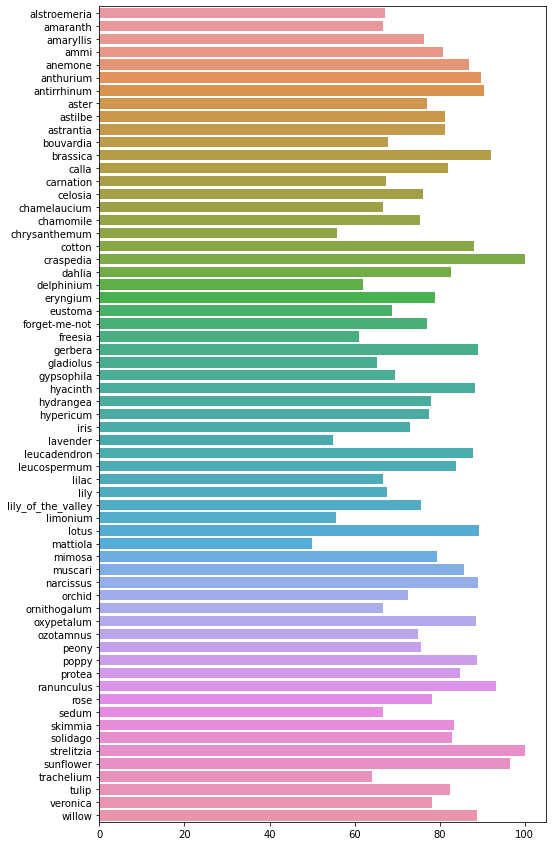

In [27]:
# Display accuracy for each class
mu.show_accuracy_for_each_class(val_dataset, predictions_effnet_b5, plot_hist=True)

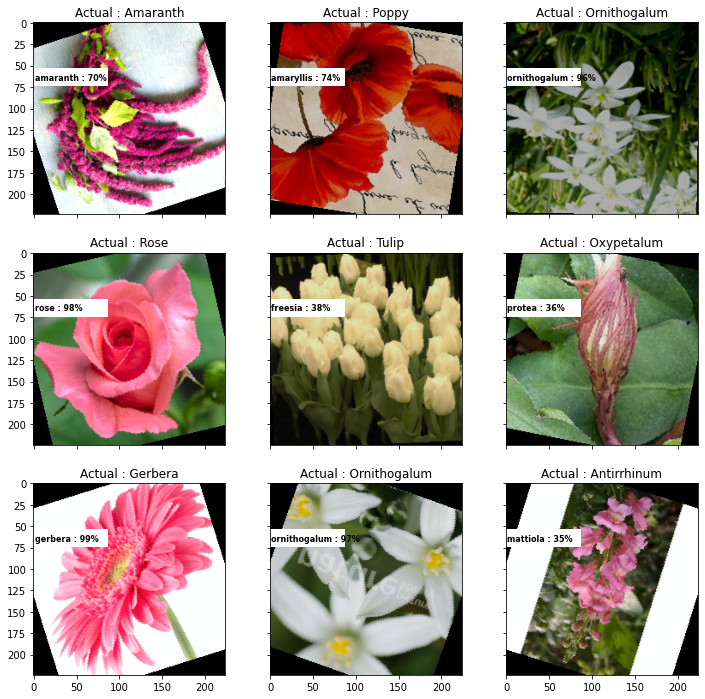

In [28]:
# Print images with true and predicted classes
mu.show_images_with_predictions(val_dataset, predictions_effnet_b5, n_samples=9)

### Training full model

#### Selection of optimal model hyperparameters

In [ ]:
def objective(trial):
    """A function to be optimized with hyperparameters."""
    # Setting the search space for hyperparameters
    params = {
        'batch_size': trial.suggest_int('batch_size', 2, 32),
        'lr': trial.suggest_loguniform('lr', 1e-6, 1e-3),
        'T_max': trial.suggest_int('T_max', 4, 100)
    }
    
    # Creating storage structures for training
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    # Setting the architecture of the neural network
    model = models.efficientnet_b5(pretrained=True)

    # Allow changing all parameters of the model
    for param in model.parameters():
        param.requires_grad = True

    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, n_classes)
    model = model.to(DEVICE)

    # Load the weights obtained at the previous stage of training
    path_to_weights = './gdrive/My Drive/flowers/models/model_effnet_b5_weights.pth'
    model.load_state_dict(load(path_to_weights)['model_state_dict'])
    
    # Setting methods for setting up a neural network
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"], amsgrad=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params['T_max'])

    # Start training a neural network with the selected parameters
    for epoch in range(3):

            train_loss, train_acc = mu.fit_epoch(model, train_loader, loss_func, optimizer, on_gpu=True)
            val_loss, val_acc = mu.eval_epoch(model, val_loader, loss_func, on_gpu=True, checkpoint=False)

            trial.report(val_acc, epoch)

            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    return val_acc

Hyperparameter fitting calculations were performed on a third-party platform (kaggle.com), so the outputs of the executed cells were not saved. The calculation results are presented below as screenshots.

In [ ]:
# Running the hyperparameter selection algorithm and displaying the results
mu.run_tuning(objective, n_trials=30, seed=SEED)

##### Results of fitting model hyperparameters

Visualize the learning curves of the trials

<img src="https://github.com/vimaki/what_is_this_flower/blob/main/predictive_model/plots/plot_intermediate_values_full.png?raw=true" width="500">

Visualize combinations of hyperparameters for all trials with display of the objective value

<img src="https://github.com/vimaki/what_is_this_flower/blob/main/predictive_model/plots/plot_parallel_coordinate_full.png?raw=true" width="500">

The projections onto the surface plane of the objective value depending on all pairs of parameters

<img src="https://github.com/vimaki/what_is_this_flower/blob/main/predictive_model/plots/plot_contour_full.png?raw=true" width="500">

Visualize parameter importances

<img src="https://github.com/vimaki/what_is_this_flower/blob/main/predictive_model/plots/plot_param_importances_full.png?raw=true" width="500">

Visualize which hyperparameters are affecting the trial duration with hyperparameter importance

<img src="https://github.com/vimaki/what_is_this_flower/blob/main/predictive_model/plots/plot_param_duration_full.png?raw=true" width="500">

<img src="https://github.com/vimaki/what_is_this_flower/blob/main/predictive_model/plots/tuning_result_full.png?raw=true" width="300">

In [30]:
BATCH_SIZE = 13
LR = 0.00023723300729921917
T_MAX = 55

#### Running full model training

In [22]:
# Load the model EfficientNet B5 pretrained on ImageNet
model_effnet_b5 = models.efficientnet_b5(pretrained=True)

# Able the computation of gradients for the all model weights
for param in model_effnet_b5.parameters():
    param.requires_grad = True

# Set a new classifier for the model
model_effnet_b5.classifier[1] = torch.nn.Linear(model_effnet_b5.classifier[1].in_features, n_classes)
model_effnet_b5 = model_effnet_b5.to(DEVICE)

# Load the weights obtained at the previous stage of training
path_to_weights = './gdrive/My Drive/flowers/models/model_effnet_b5_weights.pth'
model_effnet_b5.load_state_dict(load(path_to_weights)['model_state_dict'])

# Helper functions for training the model
loss_func_effnet_b5 = torch.nn.CrossEntropyLoss()
optimizer_effnet_b5 = torch.optim.AdamW(model_effnet_b5.parameters(), lr=LR, amsgrad=True)
scheduler_effnet_b5 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_effnet_b5, T_max=T_MAX)

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



  0%|          | 0/711 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning:

Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



loss 1.1090725140203228


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:   5%|▌         | 1/20 [14:40<4:38:39, 879.98s/it]


Epoch 001 train_loss: 1.1091     val_loss 0.7311 train_acc 0.6887 val_acc 0.7990


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.5018827723597189


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  10%|█         | 2/20 [29:02<4:20:55, 869.73s/it]


Epoch 002 train_loss: 0.5019     val_loss 0.7829 train_acc 0.8451 val_acc 0.7928


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.2686655314734703


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  15%|█▌        | 3/20 [43:35<4:06:51, 871.29s/it]


Epoch 003 train_loss: 0.2687     val_loss 0.6998 train_acc 0.9163 val_acc 0.8204


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.15602723419279307


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  20%|██        | 4/20 [58:03<3:52:01, 870.10s/it]


Epoch 004 train_loss: 0.1560     val_loss 0.6143 train_acc 0.9506 val_acc 0.8381


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.09548644399917632


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  25%|██▌       | 5/20 [1:12:34<3:37:34, 870.29s/it]


Epoch 005 train_loss: 0.0955     val_loss 0.6511 train_acc 0.9708 val_acc 0.8400


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.07163954935581342


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  30%|███       | 6/20 [1:26:46<3:21:37, 864.13s/it]


Epoch 006 train_loss: 0.0716     val_loss 0.5830 train_acc 0.9777 val_acc 0.8477


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.05984883009408365


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  35%|███▌      | 7/20 [1:40:56<3:06:14, 859.56s/it]


Epoch 007 train_loss: 0.0598     val_loss 0.6304 train_acc 0.9794 val_acc 0.8492


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.039208210012518646


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  40%|████      | 8/20 [1:55:14<2:51:45, 858.83s/it]


Epoch 008 train_loss: 0.0392     val_loss 0.5872 train_acc 0.9885 val_acc 0.8724


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.02583488979632565


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  45%|████▌     | 9/20 [2:09:30<2:37:17, 857.92s/it]


Epoch 009 train_loss: 0.0258     val_loss 0.5973 train_acc 0.9927 val_acc 0.8750


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.023152975822416832


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  50%|█████     | 10/20 [2:23:40<2:22:35, 855.57s/it]


Epoch 010 train_loss: 0.0232     val_loss 0.6558 train_acc 0.9930 val_acc 0.8544


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.02682729231530203


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  55%|█████▌    | 11/20 [2:37:47<2:07:57, 853.01s/it]


Epoch 011 train_loss: 0.0268     val_loss 0.5491 train_acc 0.9925 val_acc 0.8783


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.004070504090936085


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  60%|██████    | 12/20 [2:51:59<1:53:41, 852.73s/it]


Epoch 012 train_loss: 0.0041     val_loss 0.5646 train_acc 0.9987 val_acc 0.8831


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.0020238166767161414


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  65%|██████▌   | 13/20 [3:06:18<1:39:41, 854.48s/it]


Epoch 013 train_loss: 0.0020     val_loss 0.5336 train_acc 0.9995 val_acc 0.8831


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.003744157929136021


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  70%|███████   | 14/20 [3:20:24<1:25:12, 852.09s/it]


Epoch 014 train_loss: 0.0037     val_loss 0.5675 train_acc 0.9990 val_acc 0.8798


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.0032991306026297763


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  75%|███████▌  | 15/20 [3:34:32<1:10:53, 850.79s/it]


Epoch 015 train_loss: 0.0033     val_loss 0.5604 train_acc 0.9986 val_acc 0.8809


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.003090140446374577


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  80%|████████  | 16/20 [3:48:49<56:50, 852.61s/it]


Epoch 016 train_loss: 0.0031     val_loss 0.7012 train_acc 0.9989 val_acc 0.8599


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.0022191151896087716


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  85%|████████▌ | 17/20 [4:02:59<42:36, 852.00s/it]


Epoch 017 train_loss: 0.0022     val_loss 0.6139 train_acc 0.9995 val_acc 0.8743


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.0014114744254879416


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  90%|█████████ | 18/20 [4:17:14<28:25, 852.89s/it]


Epoch 018 train_loss: 0.0014     val_loss 0.5528 train_acc 0.9995 val_acc 0.8883


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.0003311949652125688


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  95%|█████████▌| 19/20 [4:31:37<14:15, 855.72s/it]


Epoch 019 train_loss: 0.0003     val_loss 0.5405 train_acc 1.0000 val_acc 0.8916


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.0001995458948358411


  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 100%|██████████| 20/20 [4:46:04<00:00, 858.21s/it]



Epoch 020 train_loss: 0.0002     val_loss 0.5462 train_acc 1.0000 val_acc 0.8912


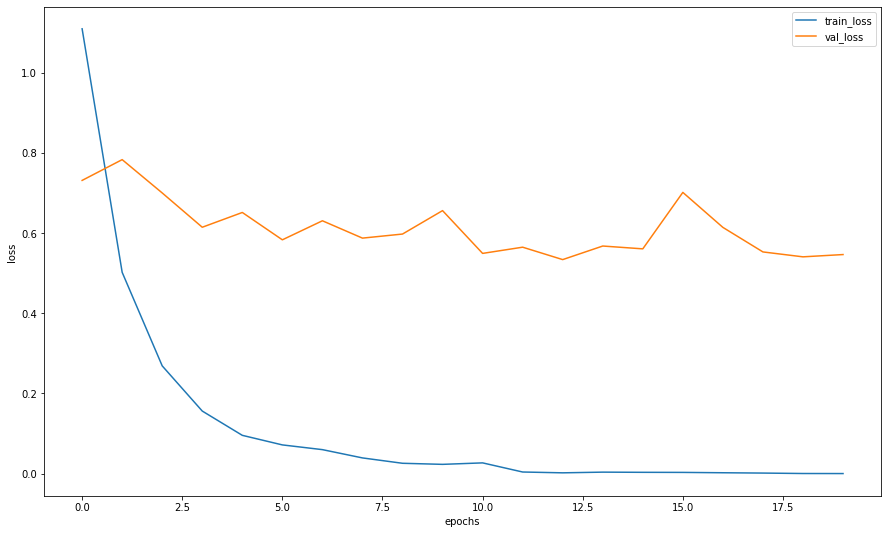

In [23]:
# Start training the model
history_effnet_b5 = mu.train(train_dataset, val_dataset, model_effnet_b5, 
                             loss_func_effnet_b5, optimizer_effnet_b5, 
                             scheduler_effnet_b5, epochs=20, batch_size=BATCH_SIZE, 
                             model_name=nameof(model_effnet_b5))

# Save model weights
torch.save({
            'model_state_dict': model_effnet_b5.state_dict(),
            'optimizer_state_dict': optimizer_effnet_b5.state_dict(),
            }, './gdrive/My Drive/flowers/models/model_effnet_b5_full_weights.pth')

# Plot learning curves for model EfficientNet B5
loss_effnet_b5, acc_effnet_b5, val_loss_effnet_b5, val_acc_effnet_b5 = zip(*history_effnet_b5)
mu.plot_epoch_loss(loss_effnet_b5, val_loss_effnet_b5)

Train the obtained model for a few more epochs

In [31]:
# Re-initialize the model and the functions necessary for training.

# Load the model EfficientNet B5 pretrained on ImageNet
model_effnet_b5 = models.efficientnet_b5(pretrained=True)

# Able the computation of gradients for the all model weights
for param in model_effnet_b5.parameters():
    param.requires_grad = True

# Set a new classifier for the model
model_effnet_b5.classifier[1] = torch.nn.Linear(model_effnet_b5.classifier[1].in_features, n_classes)
model_effnet_b5 = model_effnet_b5.to(DEVICE)

# Helper functions for training the model
loss_func_effnet_b5 = torch.nn.CrossEntropyLoss()
optimizer_effnet_b5 = torch.optim.AdamW(model_effnet_b5.parameters(), lr=LR, amsgrad=True)
scheduler_effnet_b5 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_effnet_b5, T_max=T_MAX)

In [32]:
# Loading the saved parameters of the model and the optimizer
saved_model_effnet_b5 = torch.load('./gdrive/My Drive/flowers/models/model_effnet_b5_full_weights.pth')
model_effnet_b5.load_state_dict(saved_model_effnet_b5['model_state_dict'])
optimizer_effnet_b5.load_state_dict(saved_model_effnet_b5['optimizer_state_dict'])

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



  0%|          | 0/711 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning:

Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 



loss 0.15536532133230604


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:   5%|▌         | 1/20 [08:51<2:48:08, 530.99s/it]


Epoch 001 train_loss: 0.1554     val_loss 0.4793 train_acc 0.9497 val_acc 0.8850


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.01058283326436398


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  10%|█         | 2/20 [17:24<2:36:15, 520.84s/it]


Epoch 002 train_loss: 0.0106     val_loss 0.5270 train_acc 0.9971 val_acc 0.8779


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.006459855724577751


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  15%|█▌        | 3/20 [25:51<2:25:48, 514.60s/it]


Epoch 003 train_loss: 0.0065     val_loss 0.4501 train_acc 0.9982 val_acc 0.8909


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.0026090531170074797


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  20%|██        | 4/20 [34:16<2:16:10, 510.68s/it]


Epoch 004 train_loss: 0.0026     val_loss 0.5099 train_acc 0.9992 val_acc 0.8912


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.0007133122984433428


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  25%|██▌       | 5/20 [42:40<2:07:01, 508.07s/it]


Epoch 005 train_loss: 0.0007     val_loss 0.4739 train_acc 1.0000 val_acc 0.8971


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.0023085616521128366


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  30%|███       | 6/20 [51:07<1:58:29, 507.80s/it]


Epoch 006 train_loss: 0.0023     val_loss 0.5075 train_acc 0.9997 val_acc 0.8938


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.0005633958600468162


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  35%|███▌      | 7/20 [59:35<1:50:05, 508.09s/it]


Epoch 007 train_loss: 0.0006     val_loss 0.4929 train_acc 1.0000 val_acc 0.8997


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.00031466916543274325


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  40%|████      | 8/20 [1:08:03<1:41:36, 508.00s/it]


Epoch 008 train_loss: 0.0003     val_loss 0.5353 train_acc 1.0000 val_acc 0.8842


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.00013567133543620114


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  45%|████▌     | 9/20 [1:16:30<1:33:04, 507.71s/it]


Epoch 009 train_loss: 0.0001     val_loss 0.5086 train_acc 1.0000 val_acc 0.8923


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.00014979215094005033


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  50%|█████     | 10/20 [1:25:01<1:24:46, 508.67s/it]


Epoch 010 train_loss: 0.0001     val_loss 0.4985 train_acc 1.0000 val_acc 0.8938


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.0001278936356370694


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  55%|█████▌    | 11/20 [1:33:34<1:16:30, 510.03s/it]


Epoch 011 train_loss: 0.0001     val_loss 0.4990 train_acc 1.0000 val_acc 0.9008


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.00010264128663112026


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  60%|██████    | 12/20 [1:42:05<1:08:02, 510.37s/it]


Epoch 012 train_loss: 0.0001     val_loss 0.5273 train_acc 1.0000 val_acc 0.8971


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.00033356733866165243


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  65%|██████▌   | 13/20 [1:50:37<59:35, 510.79s/it]


Epoch 013 train_loss: 0.0003     val_loss 0.5276 train_acc 0.9999 val_acc 0.8942


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.0002118293276086685


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  70%|███████   | 14/20 [1:59:06<51:01, 510.31s/it]


Epoch 014 train_loss: 0.0002     val_loss 0.5273 train_acc 1.0000 val_acc 0.8960


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.00013667943588270359


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  75%|███████▌  | 15/20 [2:07:36<42:30, 510.06s/it]


Epoch 015 train_loss: 0.0001     val_loss 0.5280 train_acc 1.0000 val_acc 0.8960


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.00044667617627405754


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  80%|████████  | 16/20 [2:16:09<34:03, 510.95s/it]


Epoch 016 train_loss: 0.0004     val_loss 0.5527 train_acc 0.9999 val_acc 0.8949


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.000149448165479397


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  85%|████████▌ | 17/20 [2:24:41<25:34, 511.35s/it]


Epoch 017 train_loss: 0.0001     val_loss 0.5184 train_acc 1.0000 val_acc 0.9015


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.00010974316011037936


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  90%|█████████ | 18/20 [2:33:12<17:02, 511.09s/it]


Epoch 018 train_loss: 0.0001     val_loss 0.5220 train_acc 1.0000 val_acc 0.8975


  0%|          | 0/711 [00:00<?, ?it/s]

loss 7.51839577239847e-05


  0%|          | 0/209 [00:00<?, ?it/s]

epoch:  95%|█████████▌| 19/20 [2:41:37<08:29, 509.31s/it]


Epoch 019 train_loss: 0.0001     val_loss 0.5142 train_acc 1.0000 val_acc 0.8990


  0%|          | 0/711 [00:00<?, ?it/s]

loss 0.0001389197761920047


  0%|          | 0/209 [00:00<?, ?it/s]

epoch: 100%|██████████| 20/20 [2:50:08<00:00, 510.41s/it]



Epoch 020 train_loss: 0.0001     val_loss 0.5401 train_acc 1.0000 val_acc 0.8942


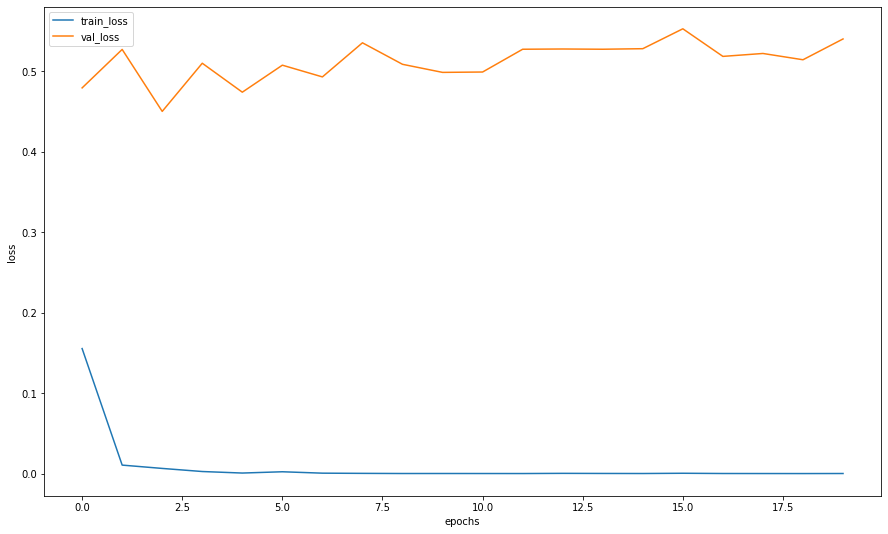

In [33]:
# Start training the model
history_effnet_b5 = mu.train(train_dataset, val_dataset, model_effnet_b5, 
                             loss_func_effnet_b5, optimizer_effnet_b5, 
                             scheduler_effnet_b5, epochs=20, batch_size=BATCH_SIZE, 
                             model_name=nameof(model_effnet_b5))

# Save model weights
torch.save({
            'model_state_dict': model_effnet_b5.state_dict(),
            'optimizer_state_dict': optimizer_effnet_b5.state_dict(),
            }, './gdrive/My Drive/flowers/models/model_effnet_b5_full_weights.pth')

# Plot learning curves for model EfficientNet B5
loss_effnet_b5, acc_effnet_b5, val_loss_effnet_b5, val_acc_effnet_b5 = zip(*history_effnet_b5)
mu.plot_epoch_loss(loss_effnet_b5, val_loss_effnet_b5)

#### Check the quality of the model on the test dataset




Loading saved model weights

In [24]:
# Load the model EfficientNet B5 pretrained on ImageNet
model_effnet_b5 = models.efficientnet_b5(pretrained=True)

# Able the computation of gradients for the all model weights
for param in model_effnet_b5.parameters():
    param.requires_grad = True

# Set a new classifier for the model
model_effnet_b5.classifier[1] = torch.nn.Linear(model_effnet_b5.classifier[1].in_features, n_classes)
model_effnet_b5 = model_effnet_b5.to(DEVICE)

# Load the weights obtained at the previous stage of training
path_to_weights = './gdrive/My Drive/flowers/models/model_effnet_b5_full_weights.pth'
model_effnet_b5.load_state_dict(load(path_to_weights)['model_state_dict'])

model_effnet_b5.eval();

Quality checking

In [25]:
# Computing model predictions
predictions_effnet_b5 = mu.predict(model_effnet_b5, test_dataset, do_tta=True)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



In [26]:
# Calculation of the F1-score
f1_effnet_b5 = mu.model_f1(test_dataset, predictions_effnet_b5)
f1_effnet_b5

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



0.8896570796460177

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Normalized confusion matrix


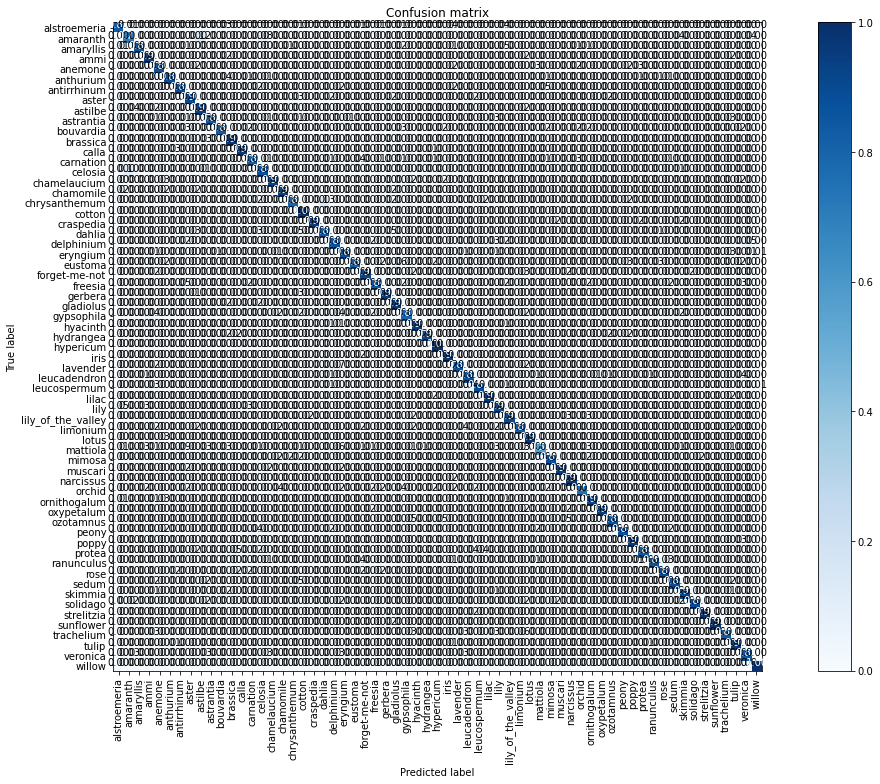

In [27]:
# Display the distribution of accuracy by class as a confusion matrix
y_test_all_effnet_b5, predictions_all_effnet_b5 = mu.show_confusion_matrix_func(
    test_dataset, predictions_effnet_b5);

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Accuracy of alstroemeria        83.8%
Accuracy of amaranth            70.8%
Accuracy of amaryllis           85.9%
Accuracy of ammi                94.6%
Accuracy of anemone             87.5%
Accuracy of anthurium           88.8%
Accuracy of antirrhinum         89.1%
Accuracy of aster               90.8%
Accuracy of astilbe             92.6%
Accuracy of astrantia           85.3%
Accuracy of bouvardia           83.9%
Accuracy of brassica            97.1%
Accuracy of calla               96.1%
Accuracy of carnation           82.4%
Accuracy of celosia             88.1%
Accuracy of chamelaucium        92.1%
Accuracy of chamomile           93.3%
Accuracy of chrysanthemum       80.3%
Accuracy of cotton             100.0%
Accuracy of craspedia           95.4%
Accuracy of dahlia              83.5%
Accuracy of delphinium          86.2%
Accuracy of eryngium            88.3%
Accuracy of eustoma             81.2%
Accuracy of forget-me-not       90.6%
Accuracy of freesia             84.4%
Accuracy of 

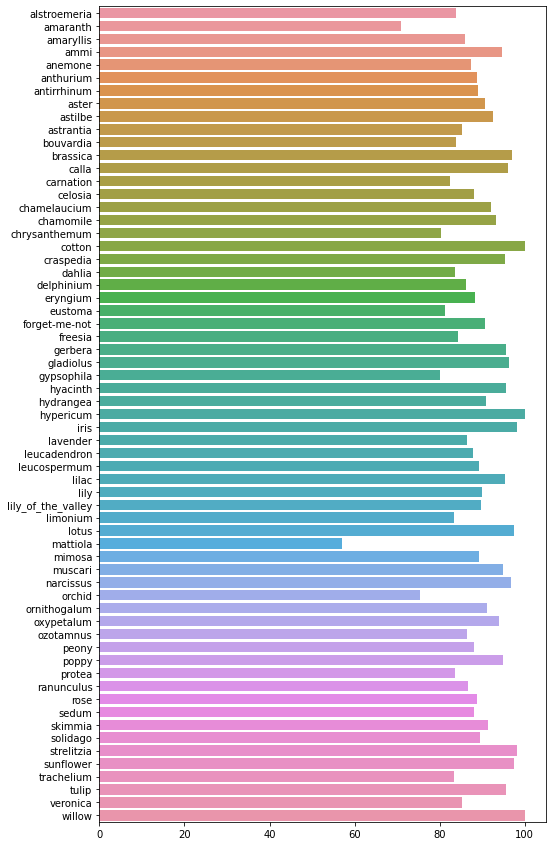

In [28]:
# Display accuracy for each class
mu.show_accuracy_for_each_class(test_dataset, predictions_effnet_b5, plot_hist=True)

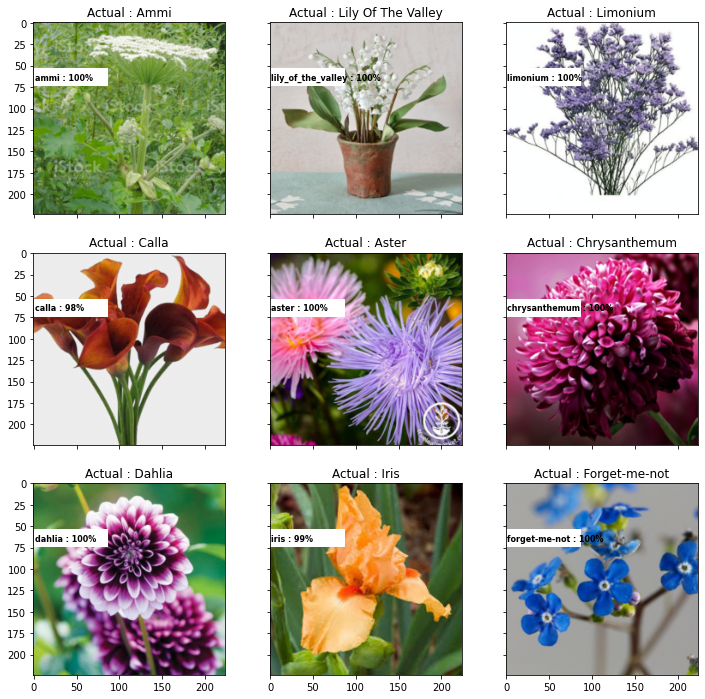

In [32]:
# Print images with true and predicted classes
mu.show_images_with_predictions(test_dataset, predictions_effnet_b5, n_samples=9)